In [1]:
import numpy as np
import pandas as pd

import requests 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import folium 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

%matplotlib inline

In [2]:
# import the rental cost of Vienna and convert to dataframe
miete = pd.read_html('https://www.virtualvienna.net/moving-to-vienna/accommodation/real-estate-rental-prices/',decimal=',', na_values="k.A.", thousands=".") 
Miete = miete[0] 

In [3]:
Miete['PostalCode'] = ['1010', '1020', '1030','1040','1050','1060','1070','1080','1090','1100','1110','1120','1130','1140','1150','1160','1170','1180','1190','1200','1210','1220','1230']

In [4]:
Miete = Miete[['PostalCode', 'District', 'average/m²']]
Miete.head()

,PostalCode,District,average/m²
0,1010,"1., Innere Stadt",19.44
1,1020,"2., Leopoldstadt",14.57
2,1030,"3., Landstraße",14.51
3,1040,"4., Wieden",14.74
4,1050,"5., Margareten",14.84


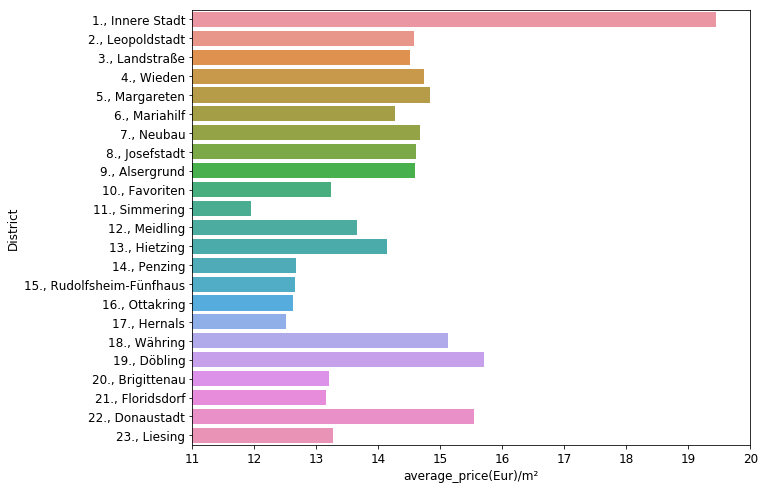

In [5]:
plt.rcParams['figure.figsize'] = 10, 8
sns.barplot(data=Miete, x = 'average/m²', y = 'District')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("District", fontsize = 12, color="Black")
plt.xlabel("average_price(Eur)/m²", fontsize = 12, color="Black")
ax = plt.gca()
ax.set_xlim([11,20])
plt.show()

In [6]:
#neighborhood = pd.read_csv('https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:GEONAMENOGD&srsName=EPSG:4326&outputFormat=csv')
neighborhood = pd.read_csv('~/Downloads/GEONAMENOGD.csv')
neighborhood = neighborhood[['LOCALITYLIST','SHAPE','FEATURENAME', ]]

In [7]:
neighborhood = neighborhood[~pd.isna(neighborhood['LOCALITYLIST'])] 
neighborhood = neighborhood[~neighborhood['LOCALITYLIST'].str.contains(";")]  

In [8]:
neighborhood['SHAPE'] = neighborhood['SHAPE'].str[7: -2]

In [9]:
split = neighborhood['SHAPE'].str.split(" ", n = -1, expand = True)

In [10]:
neighborhood['Longitude'] = split[0]
neighborhood['Latitude'] = split[1]

In [11]:
neighborhood.drop(['SHAPE'], axis = 1, inplace = True)

In [12]:
neighborhood['LOCALITYLIST'].astype(str)
neighborhood['LOCALITYLIST'] = '1' + neighborhood['LOCALITYLIST'] + '0'

In [13]:
neighborhood = neighborhood.rename({'LOCALITYLIST': 'PostalCode','FEATURENAME': 'Neighborhood' }, axis=1) 

In [14]:
neighborhood.shape

(4419, 4)

In [15]:
neighborhood['PostalCode'].unique()

array(['1090', '1150', '1100', '1010', '1190', '1220', '1020', '1200',
       '1180', '1130', '1210', '1040', '1060', '1030', '1070', '1120',
       '1170', '1160', '1140', '1080', '1230', '1050', '1110', '110'], dtype=object)

In [16]:
neighborhood.loc[neighborhood['PostalCode'] == '110','PostalCode'] = '1010'

In [17]:
Vie=pd.merge(Miete, neighborhood, on='PostalCode')

In [18]:
Vie['Neighborhood'].head()

0                    Universität für angewandte Kunst
1                         Akademie der Wissenschaften
2    Musik und Kunst Privatuniversität der Stadt Wien
3    Musik und Kunst Privatuniversität der Stadt Wien
4                    Konservatorium Wien Singerstraße
Name: Neighborhood, dtype: object

In [19]:
Vie['Longitude'] = Vie['Longitude']. astype(float)
Vie['Latitude'] = Vie['Latitude']. astype(float)

In [20]:
address = 'Vienna'

geolocator = Nominatim(user_agent="Vienna_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vienna City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vienna City are 48.2083537, 16.3725042.


In [21]:
district = Vie['PostalCode'].unique()

In [22]:
district

array(['1010', '1020', '1030', '1040', '1050', '1060', '1070', '1080',
       '1090', '1100', '1110', '1120', '1130', '1140', '1150', '1160',
       '1170', '1180', '1190', '1200', '1210', '1220', '1230'], dtype=object)

In [23]:
Vienna = pd.DataFrame()
for i in district:
    d1 = Vie[Vie['PostalCode'] == i].sample(n=5)
    Vienna = Vienna.append(d1)

In [24]:
Vienna = Vienna.reset_index(drop=True)

In [25]:
map_Vienna = folium.Map(location=[latitude, longitude], zoom_start=12)

In [26]:
for lat, lng, neighborhood, PostCode in zip(Vienna['Latitude'], Vienna['Longitude'], Vienna['Neighborhood'], Vienna['PostalCode']):
    label = '{}, {}'.format(neighborhood, PostCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Vienna)  
    
map_Vienna

In [27]:
CLIENT_ID = 'ASTVFHRB5LE1HCTUHZTDRDRKAKMKLU0R3I03AGJSPWTTPX5M' # your Foursquare ID
CLIENT_SECRET = '50JYEAMD1A01JY5CCASMOV0EGBPDXRR0FERAHRNOPOJM3JJO' #your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ASTVFHRB5LE1HCTUHZTDRDRKAKMKLU0R3I03AGJSPWTTPX5M
CLIENT_SECRET:50JYEAMD1A01JY5CCASMOV0EGBPDXRR0FERAHRNOPOJM3JJO


In [28]:
Vienna.shape

(115, 6)

In [29]:
innerstadt_latitude = Vienna.loc[0, 'Latitude'] # neighborhood latitude value
innerstadt_longitude = Vienna.loc[0, 'Longitude'] # neighborhood longitude value
District_name = Vienna.loc[0, 'District'] # neighborhood name

print(District_name, innerstadt_latitude, innerstadt_longitude, )

1., Innere Stadt 48.2093446371 16.3654203511


In [30]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    innerstadt_latitude, 
    innerstadt_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ASTVFHRB5LE1HCTUHZTDRDRKAKMKLU0R3I03AGJSPWTTPX5M&client_secret=50JYEAMD1A01JY5CCASMOV0EGBPDXRR0FERAHRNOPOJM3JJO&v=20180605&ll=48.209344637056,16.365420351084474&radius=500&limit=100'

In [31]:
results = requests.get(url).json()

In [32]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Michaelerplatz,Plaza,48.208007,16.366625
1,Beaulieu,French Restaurant,48.210841,16.365329
2,Giorgina,Restaurant,48.210601,16.363979
3,Park Hyatt Vienna,Hotel,48.210691,16.367788
4,Zum Schwarzen Kameel,Restaurant,48.210010,16.368240


In [34]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [35]:
# create a function to repeat the same process to all the district
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
Vienna_venues=Vienna['District']

In [37]:
Vienna_venues = getNearbyVenues(names=Vienna['Neighborhood'],
                                   latitudes=Vienna['Latitude'],
                                   longitudes=Vienna['Longitude']
                                  )

U-Bahn Station Herrengasse
Kaiser-Franz-I.-Stephan-von-Lothringen-Denkmal
Friedrich-Freiherr-von-Schmidt-Denkmal
Amerling-Denkmal
Virgilkapelle
Seitenhafen
Wachauer Hof
Johann-Kallinich-Denkmal
Zirkuswiese
Bahnhof Donauuferbahn
Eduard-Suess-Denkmal
Richard-Strauß-Hof
Fiaker-Denkmal
Village-Galerie
TU Arsenal
U-Bahn Station Südtiroler Platz Hauptbahnhof
Freie Bühne Wieden
Siegfried-Marcus-Denkmal
Josef-Madersperger-Denkmal
Sir-Karl-Popper Schule
Magistratisches Bezirksamt 4.u.5.Bezirk
Friederike-Seidl-Hof
Willi-Frank-Park
Klieberpark
Herweghhof
Gänsemädchenbrunnen
Richard-Waldemar-Park
KG Mariahilf
Johanna-Prangl-Hof
Helene-Heppe-Park
KG Neubau
Museumsquartier
Museum der Mechitharistenkongregation
Dschungel Wien-Theaterhaus für junges Publikum
U-Bahn Station Burggasse
Theatro Kosilo
Stefan-Zweig-Archiv
Gartenanlage Wickenburggasse
Wiener Schuhmuseum
U-Bahn Station Josefstädter Straße
Heinz-Heger-Park
Uni Wien Informatik
Uni Wien Sozialwissenschaften
Geldmuseum
Sanatorium Hera
Buttingert

In [38]:
len(Vienna_venues)

3600

In [39]:
print(Vienna_venues.shape)
Vienna_venues

(3600, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,U-Bahn Station Herrengasse,48.209345,16.365420,Michaelerplatz,48.208007,16.366625,Plaza
1,U-Bahn Station Herrengasse,48.209345,16.365420,Beaulieu,48.210841,16.365329,French Restaurant
2,U-Bahn Station Herrengasse,48.209345,16.365420,Giorgina,48.210601,16.363979,Restaurant
3,U-Bahn Station Herrengasse,48.209345,16.365420,Park Hyatt Vienna,48.210691,16.367788,Hotel
4,U-Bahn Station Herrengasse,48.209345,16.365420,Zum Schwarzen Kameel,48.210010,16.368240,Restaurant
5,U-Bahn Station Herrengasse,48.209345,16.365420,Café Central,48.210348,16.365391,Café
6,U-Bahn Station Herrengasse,48.209345,16.365420,Kohlmarkt,48.208330,16.366840,Shopping Plaza
7,U-Bahn Station Herrengasse,48.209345,16.365420,Julius Meinl,48.209416,16.368588,Gourmet Shop
8,U-Bahn Station Herrengasse,48.209345,16.365420,Sisi Museum,48.207789,16.365740,History Museum
9,U-Bahn Station Herrengasse,48.209345,16.365420,Vapiano,48.209593,16.366327,Italian Restaurant


In [40]:
Vienna_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Am Bahndamm,4,4,4,4,4,4
Amerling-Denkmal,94,94,94,94,94,94
Anschüttbrückl,1,1,1,1,1,1
Anton-Proksch-Wohnhausanlage,9,9,9,9,9,9
Aspern Seestadt,8,8,8,8,8,8
Bahnhof Brünner Straße,32,32,32,32,32,32
Bahnhof Donauuferbahn,7,7,7,7,7,7
Bezirksmuseum Brigittenau,14,14,14,14,14,14
Bill-Grah-Park-Teich,5,5,5,5,5,5


In [41]:
print('There are {} uniques categories.'.format(len(Vienna_venues['Venue Category'].unique())))

There are 268 uniques categories.


In [42]:
Vienna_onehot = pd.get_dummies(Vienna_venues[['Venue Category']], prefix="", prefix_sep="")
Vienna_onehot['Neighborhood'] = Vienna_venues['Neighborhood'] 
Vienna_onehot.head(10)

,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,U-Bahn Station Herrengasse


In [43]:
# move neighborhood column to the first column
fixed_columns = [Vienna_onehot.columns[-1]] + list(Vienna_onehot.columns[:-1])
Vienna_onehot = Vienna_onehot[fixed_columns]
Vienna_onehot.head(100)

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,U-Bahn Station Herrengasse,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
Vienna_onehot.shape

(3600, 269)

In [45]:
Vienna_grouped = Vienna_onehot.groupby('Neighborhood').mean().reset_index()
Vienna_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Am Bahndamm,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
1,Amerling-Denkmal,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.010638,0.000000,0.000000,...,0.010638,0.000000,0.000000,0.0,0.00,0.042553,0.010638,0.0,0.000000,0.0
2,Anschüttbrückl,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
3,Anton-Proksch-Wohnhausanlage,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.111111,0.000000,0.0,0.000000,0.0
4,Aspern Seestadt,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
5,Bahnhof Brünner Straße,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
6,Bahnhof Donauuferbahn,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
7,Bezirksmuseum Brigittenau,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
8,Bill-Grah-Park-Teich,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0
9,Businesspark Marximum,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0


In [46]:
Vienna_grouped.shape

(111, 269)

In [47]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in Vienna_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Vienna_grouped[Vienna_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Am Bahndamm----
               venue  freq
0      Train Station  0.25
1         Campground  0.25
2            Dog Run  0.25
3         Restaurant  0.25
4  Accessories Store  0.00


----Amerling-Denkmal----
                 venue  freq
0  Austrian Restaurant  0.13
1                Hotel  0.09
2   Italian Restaurant  0.09
3           Restaurant  0.07
4                 Café  0.06


----Anschüttbrückl----
                 venue  freq
0                Plaza   1.0
1         Optical Shop   0.0
2  Moroccan Restaurant   0.0
3      Motorcycle Shop   0.0
4        Movie Theater   0.0


----Anton-Proksch-Wohnhausanlage----
                venue  freq
0            Gym Pool  0.11
1            Bus Stop  0.11
2              Market  0.11
3            Wine Bar  0.11
4  Italian Restaurant  0.11


----Aspern Seestadt----
                     venue  freq
0                     Park  0.12
1              Pizza Place  0.12
2                      Pub  0.12
3  Fruit & Vegetable Store  0.12
4                   

                    venue  freq
0               Gastropub  0.25
1  Gluten-free Restaurant  0.25
2             Supermarket  0.25
3            Hockey Field  0.25
4                  Museum  0.00


----KLG Kreuzbau----
          venue  freq
0  Tram Station  0.29
1  Dance Studio  0.14
2      Bus Stop  0.14
3     Gastropub  0.14
4    Smoke Shop  0.14


----KLG Meisenbühel----
                 venue  freq
0        Moving Target   1.0
1    Accessories Store   0.0
2         Optical Shop   0.0
3  Moroccan Restaurant   0.0
4      Motorcycle Shop   0.0


----KLG Predigtstuhl----
                    venue  freq
0                   Trail   0.2
1             Supermarket   0.2
2               Gastropub   0.2
3            Hockey Field   0.2
4  Gluten-free Restaurant   0.2


----KLG SDL Laaerwald----
                 venue  freq
0              Dog Run  0.33
1        Train Station  0.17
2                 Park  0.17
3  Austrian Restaurant  0.17
4           Restaurant  0.17


----KLG Schafberghöhe----
    

----Sportplatz Siebenhirten----
                         venue  freq
0              Motorcycle Shop  0.11
1               Cosmetics Shop  0.11
2                  Fabric Shop  0.11
3                  Flower Shop  0.11
4  Eastern European Restaurant  0.11


----St. Josef Krankenhaus----
            venue  freq
0    Soccer Field  0.14
1  Soccer Stadium  0.10
2   Deli / Bodega  0.05
3      Restaurant  0.05
4        Bus Stop  0.05


----Stadthallenbad----
                 venue  freq
0         Concert Hall  0.08
1           Restaurant  0.08
2               Bakery  0.08
3     Kebab Restaurant  0.04
4  Austrian Restaurant  0.04


----Stefan-Zweig-Archiv----
                venue  freq
0               Hotel  0.11
1  Italian Restaurant  0.10
2                Café  0.07
3        Cocktail Bar  0.06
4          Restaurant  0.06


----TU Arsenal----
                venue  freq
0            Bus Stop  0.33
1              Casino  0.17
2         Art Gallery  0.17
3         Supermarket  0.17
4  Light Rai

In [48]:
# Let's put that into a *pandas* dataframe
# First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Vienna_grouped['Neighborhood']

for ind in np.arange(Vienna_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Vienna_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Am Bahndamm,Dog Run,Campground,Train Station,Restaurant,Zoo Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
1,Amerling-Denkmal,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Café,Bar,Wine Bar,Steakhouse,Bakery,Cocktail Bar
2,Anschüttbrückl,Plaza,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market
3,Anton-Proksch-Wohnhausanlage,Italian Restaurant,Greek Restaurant,Wine Bar,Bus Stop,Market,History Museum,Gym Pool,Cocktail Bar,Austrian Restaurant,Fast Food Restaurant
4,Aspern Seestadt,Pizza Place,Park,Bakery,Austrian Restaurant,Pub,Fruit & Vegetable Store,Metro Station,Lake,Flower Shop,Food


In [50]:
neighborhoods_venues_sorted.shape

(111, 11)

In [51]:
# set number of clusters
kclusters = 10
Vienna_grouped_clustering = Vienna_grouped.drop('Neighborhood', 1)

In [52]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 1, 4, 5, 5, 5, 5, 5, 5, 1, 1, 0, 5, 5, 1, 1, 1, 5, 3, 1, 5, 1, 1,
       1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 0, 5, 1, 5, 1, 9, 1, 1, 0, 0,
       8, 0, 5, 5, 5, 5, 1, 5, 0, 6, 5, 5, 1, 1, 1, 5, 5, 1, 1, 5, 5, 5, 1,
       5, 7, 5, 1, 1, 5, 1, 1, 0, 5, 1, 0, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [53]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 1, 4, 5, 5, 5, 5, 5, 5, 1], dtype=int32)

In [54]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Vienna_merged = Vienna

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Vienna_merged = Vienna_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Vienna_merged.head() # check the last columns!

,PostalCode,District,average/m²,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,"1., Innere Stadt",19.44,U-Bahn Station Herrengasse,16.365420,48.209345,1.0,Restaurant,Plaza,Café,Boutique,Italian Restaurant,Coffee Shop,Bar,History Museum,Hotel,Park
1,1010,"1., Innere Stadt",19.44,Kaiser-Franz-I.-Stephan-von-Lothringen-Denkmal,16.365153,48.204499,1.0,Plaza,Café,Museum,Hotel,Restaurant,Italian Restaurant,History Museum,Historic Site,Art Museum,Austrian Restaurant
2,1010,"1., Innere Stadt",19.44,Friedrich-Freiherr-von-Schmidt-Denkmal,16.355937,48.211484,1.0,Café,Hotel,Restaurant,Italian Restaurant,Gastropub,Bar,Theater,Austrian Restaurant,Park,Coffee Shop
3,1010,"1., Innere Stadt",19.44,Amerling-Denkmal,16.379936,48.205541,1.0,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Café,Bar,Wine Bar,Steakhouse,Bakery,Cocktail Bar
4,1010,"1., Innere Stadt",19.44,Virgilkapelle,16.371979,48.208333,1.0,Café,Restaurant,Italian Restaurant,Austrian Restaurant,Cocktail Bar,Ice Cream Shop,Hotel,Plaza,Boutique,Wine Bar


In [55]:
Vienna_merged = Vienna_merged.dropna(axis=0, how='any')

In [56]:
Vienna_merged['Cluster Labels'] = Vienna_merged['Cluster Labels'].astype(int)

In [57]:
type(Vienna_merged['Cluster Labels'][0])

numpy.int64

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [59]:
# add markers to the map
iter = zip(Vienna_merged['Latitude'], 
           Vienna_merged['Longitude'], 
           Vienna_merged['Neighborhood'], 
           Vienna_merged['Cluster Labels'])
for lat, lon, poi, cluster in iter:
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [60]:
cluster0 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 0, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster0

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,1020,"2., Leopoldstadt",14.57,48.207282,0,Playground,Park,Restaurant,Tennis Court,Lake,Beer Garden,Baseball Field,Bike Rental / Bike Share,Sports Club,Trail
65,1140,"14., Penzing",12.68,48.215265,0,Business Service,Field,Zoo Exhibit,Exhibit,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop
66,1140,"14., Penzing",12.68,48.209193,0,Business Service,Park,Lake,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Exhibit,Food Service
67,1140,"14., Penzing",12.68,48.207797,0,Business Service,Austrian Restaurant,Bus Stop,Park,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market
76,1160,"16., Ottakring",12.63,48.223366,0,Gluten-free Restaurant,Hockey Field,Supermarket,Gastropub,Zoo Exhibit,Field,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
81,1170,"17., Hernals",12.51,48.229910,0,Tram Station,Dance Studio,Bus Stop,Beer Garden,Gastropub,Smoke Shop,Food & Drink Shop,Food,Flower Shop,Food Court
82,1170,"17., Hernals",12.51,48.223911,0,Gastropub,Trail,Gluten-free Restaurant,Hockey Field,Supermarket,Zoo Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
86,1180,"18., Währing",15.12,48.235458,0,Bus Stop,Park,Gastropub,Hotel,Playground,Planetarium,Food Court,Food & Drink Shop,Food,Flower Shop
93,1190,"19., Döbling",15.71,48.237852,0,Park,Bus Stop,Soccer Field,Supermarket,Gastropub,Café,Playground,Plaza,Szechuan Restaurant,Falafel Restaurant
112,1230,"23., Liesing",13.27,48.150698,0,Lake,Forest,River,Sculpture Garden,Fast Food Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Zoo Exhibit


In [61]:
cluster1 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 1, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster1

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,"1., Innere Stadt",19.44,48.209345,1,Restaurant,Plaza,Café,Boutique,Italian Restaurant,Coffee Shop,Bar,History Museum,Hotel,Park
1,1010,"1., Innere Stadt",19.44,48.204499,1,Plaza,Café,Museum,Hotel,Restaurant,Italian Restaurant,History Museum,Historic Site,Art Museum,Austrian Restaurant
2,1010,"1., Innere Stadt",19.44,48.211484,1,Café,Hotel,Restaurant,Italian Restaurant,Gastropub,Bar,Theater,Austrian Restaurant,Park,Coffee Shop
3,1010,"1., Innere Stadt",19.44,48.205541,1,Austrian Restaurant,Hotel,Italian Restaurant,Restaurant,Café,Bar,Wine Bar,Steakhouse,Bakery,Cocktail Bar
4,1010,"1., Innere Stadt",19.44,48.208333,1,Café,Restaurant,Italian Restaurant,Austrian Restaurant,Cocktail Bar,Ice Cream Shop,Hotel,Plaza,Boutique,Wine Bar
6,1020,"2., Leopoldstadt",14.57,48.221488,1,Restaurant,Noodle House,Italian Restaurant,Café,Mediterranean Restaurant,Sandwich Place,Market,Boat or Ferry,Fast Food Restaurant,Fruit & Vegetable Store
8,1020,"2., Leopoldstadt",14.57,48.211956,1,Restaurant,Theme Park Ride / Attraction,Beer Garden,Nightclub,Café,Mexican Restaurant,American Restaurant,Hockey Arena,Bowling Alley,Diner
10,1030,"3., Landstraße",14.51,48.198366,1,Café,Hotel,Concert Hall,Austrian Restaurant,Supermarket,Restaurant,Theater,Plaza,Burrito Place,Bar
11,1030,"3., Landstraße",14.51,48.198625,1,Hotel,Austrian Restaurant,Concert Hall,Pizza Place,Restaurant,Café,Lounge,Supermarket,Theater,Gift Shop
13,1030,"3., Landstraße",14.51,48.207834,1,Café,Hotel,Art Museum,Restaurant,Supermarket,Trattoria/Osteria,Eastern European Restaurant,Asian Restaurant,Austrian Restaurant,Tram Station


In [62]:
cluster2 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 2, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster2

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,1110,"11., Simmering",11.95,48.148561,2,Flower Shop,Zoo Exhibit,Event Space,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,Flea Market,Fish Market


In [63]:
cluster3 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 3, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster3

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,1130,"13., Hietzing",14.14,48.152938,3,Dog Run,Zoo Exhibit,Fish Market,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Event Space


In [64]:
cluster5 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 4, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster5

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
108,1220,"22., Donaustadt",15.54,48.168658,4,Plaza,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market


In [65]:
cluster6 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 5, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster6

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,1020,"2., Leopoldstadt",14.57,48.180990,5,Train Station,Auto Workshop,Harbor / Marina,Zoo Exhibit,Fast Food Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Field
9,1020,"2., Leopoldstadt",14.57,48.230143,5,Bus Stop,Food & Drink Shop,Harbor / Marina,Supermarket,Bar,Hotel,Food Court,Food,Flower Shop,Food Service
12,1030,"3., Landstraße",14.51,48.196337,5,Bus Stop,Tram Station,Supermarket,Gastropub,Grocery Store,Restaurant,Pharmacy,Museum,German Restaurant,Martial Arts Dojo
14,1030,"3., Landstraße",14.51,48.179371,5,Bus Stop,Art Gallery,Light Rail Station,Supermarket,Casino,Food & Drink Shop,Food Court,Food,Food Service,Falafel Restaurant
19,1040,"4., Wieden",14.74,48.184852,5,Restaurant,BBQ Joint,Supermarket,Park,Bakery,Trattoria/Osteria,Dive Bar,Gym / Fitness Center,Austrian Restaurant,Bar
23,1050,"5., Margareten",14.84,48.184639,5,Restaurant,Supermarket,Park,Austrian Restaurant,Athletics & Sports,Gym / Fitness Center,Light Rail Station,BBQ Joint,Liquor Store,Tram Station
24,1050,"5., Margareten",14.84,48.180993,5,Tram Station,Pizza Place,Hotel,Food Court,Fast Food Restaurant,Park,Pub,Bulgarian Restaurant,Supermarket,Hookah Bar
46,1100,"10., Favoriten",13.23,48.158086,5,Metro Station,Fast Food Restaurant,Pool,Tram Station,Park,Café,Bus Stop,Zoo Exhibit,Field,Falafel Restaurant
48,1100,"10., Favoriten",13.23,48.160111,5,Garden,Bus Stop,Soccer Field,Dog Run,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Zoo Exhibit
49,1100,"10., Favoriten",13.23,48.164325,5,Dog Run,Train Station,Restaurant,Austrian Restaurant,Park,Zoo Exhibit,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market


In [66]:
cluster7 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 6, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster7

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,1140,"14., Penzing",12.68,48.224422,6,Trail,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market,Forest


In [67]:
cluster8 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 7, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster8

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,1190,"19., Döbling",15.71,48.271142,7,Wine Bar,Trail,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Flea Market


In [68]:
cluster9 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 8, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster9

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,1130,"13., Hietzing",14.14,48.185668,8,Moving Target,Zoo Exhibit,Event Space,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market


In [69]:
cluster10 = Vienna_merged.loc[
    Vienna_merged['Cluster Labels'] == 9, 
    Vienna_merged.columns[list(range(0, 3)) + list(range(5, Vienna_merged.shape[1]))]]
cluster10

,PostalCode,District,average/m²,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,1160,"16., Ottakring",12.63,48.221257,9,Scenic Lookout,Zoo Exhibit,Event Space,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
